In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import arviz as az
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import pystan
%load_ext jupyterstan

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
STAN_MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "stan_models")
STAN_DATA_PATH = os.path.join(PROJECT_ROOT_DIR,'data')

## 几个有用的函数
- save_fig:用于保存仿真的图片到文件

- StanModel_cache: 保存编译好的Stan模型

- StanModel_load: 载入保存的Stan模型

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

# 将编译好的模型，存储成pickle，供直接使用
def StanData_cache(var, data_name, **kwargs):
    path = os.path.join(STAN_DATA_PATH, data_name + '.pkl')
    with open(path,'wb') as f:
        pickle.dump(var, f)
    print("DATA cached as:" + data_name +'.pkl')
    
    
def StanData_load(data_name):
    path = os.path.join(STAN_DATA_PATH, data_name + '.pkl')
    try:
        sm = pickle.load(open(path, 'rb'))
    except:
        raise FileNotFoundError
    else:
        print("Using cached StanDATA: " + data_name)
    return sm

# 将编译好的模型，存储成pickle，供直接使用
def StanModel_cache(compiled_model, model_name, **kwargs):
    path = os.path.join(STAN_MODEL_PATH, model_name + '.pkl')
    with open(path,'wb') as f:
        pickle.dump(compiled_model, f)
    print("Model cached as:" + model_name +'.pkl')
    
    
def StanModel_load(model_name):
    path = os.path.join(STAN_MODEL_PATH, model_name + '.pkl')
    try:
        sm = pickle.load(open(path, 'rb'))
    except:
        raise FileNotFoundError
    else:
        print("Using cached StanModel")
    return sm

## 数据生成

### 函数定义

In [5]:
def gen_transmmition_data(i_group_num, i_random_seed,l_trans_power):
    '''
    该函数随机生成生成发送节点的x，y坐标值和发送功率
    Parameters
        ----------
        group_num: int,数据的组数
        random_seed: int,随机数种子
        l_trans_power: iterable,功率值
    Returns
        ----------
        transmmition_data: xarray格式  
    '''
    if (len(l_trans_power) != i_group_num):
        raise ValueError("功率值列表长度应与数据组数一致")

    np.random.seed(i_random_seed)
    trans_x = 0.5 + np.random.rand(i_group_num)*(499.5-0.5)
    trans_y = -499.5 + np.random.rand(i_group_num)*(-0.5+499.5)
    trans_power = np.array([i for i in l_trans_power])
    data = np.stack((trans_x, trans_y, trans_power))
    transmmition_data = xr.DataArray(data,
                              dims=('var', 'group'),
                              coords={'var':['x','y','power']}
                             )
    return transmmition_data


def recv_power(xr_transmmiton_data, coord_x, coord_y, r_η):
    '''
    该函数根据transmmiton_data，节点坐标recv_x, recv_y, 自由空间传播损耗因子η，生成每个节点的接收功率
    Parameters
        ----------
        xr_transmmion_data: xarray,发送节点数据,dims{var,group}
        recv_x: np.meshgrid生成的x坐标
        recv_y: np.meshgrid生成的y坐标
        r_η: real,自由空间传播损耗
    Returns
        ----------
        spectrum_data: xarray格式<xarray.DataArray (y: 500, x: 500, group: n)>    
    '''
    recv_x, recv_y = np.meshgrid(coord_x, coord_y)
    groups = xr_transmmiton_data.sizes['group']
    temp_array = np.zeros(shape=(len(recv_x), len(recv_y), groups))
    for group_num in range(groups):
        trans_x , trans_y, trans_power = xr_transmmiton_data.sel(group=group_num).values
        recv_power = trans_power - 10 * r_η * np.log10( np.sqrt(np.square(recv_x-trans_x)
               +np.square(recv_y-trans_y)) )
        temp_array[:,:,group_num] = recv_power
    
    spectrum_data = xr.DataArray(temp_array,
                             dims=('y', 'x', 'group'),
                            coords={'x':coord_x , 'y':coord_y})
        
    return spectrum_data


### 生成过程

In [4]:
# 生成发送数据
transmmition_data = gen_transmmition_data(20, 1234, [30, 50,40, 30, 40, 50, 30, 40, 50,30, 50,40, 30, 40, 50, 30, 40, 50,35,35])

# 生成只考虑自由空间传播损耗的数据
coord_x = np.arange(0.5, 500, 1)
coord_y = np.arange(-499.5, 0, 1)
free_loss_data = recv_power(transmmition_data, coord_x, coord_y, 3.5)


#添加阴影衰落效应的影响
rf = xr.open_dataset('random_fields_20.nc')
shadow_loss_data = free_loss_data + rf.shadow_loss

In [7]:
# 生成发送数据
transmmition_data_2 = gen_transmmition_data(100, 1234, 50* np.ones(100))

# 生成只考虑自由空间传播损耗的数据
coord_x = np.arange(0.5, 500, 1)
coord_y = np.arange(-499.5, 0, 1)
free_loss_data_2 = recv_power(transmmition_data_2, coord_x, coord_y, 3.5)


#添加阴影衰落效应的影响
rf2 = xr.open_dataset('random_fields_100.nc')
shadow_loss_data_2 = free_loss_data_2 + rf2.shadow_loss

In [8]:
shadow_loss_data_2

<xarray.DataArray (y: 500, x: 500, group: 100)>
array([[[-40.2585328 , -38.35115328, -51.63905768, ..., -33.76869851,
         -48.95921027, -39.15455136],
        [-55.51350983, -50.83589057, -49.38589914, ..., -51.63627869,
         -32.44136341, -54.96214862],
        [-34.32291075, -41.89322176, -54.89343621, ..., -47.97573342,
         -37.49891183, -53.54383508],
        ...,
        [-47.42728737, -44.44448209, -49.20431508, ..., -12.08629756,
         -44.52608825, -47.25970937],
        [-41.24369076, -41.47127979, -59.72451319, ..., -29.51630259,
         -53.49915886, -42.70301271],
        [-41.25060852, -38.82209311, -51.58796733, ..., -17.03638919,
         -40.93652586, -31.73797729]],

       [[-43.13769125, -59.09839745, -44.91379469, ..., -41.02097431,
         -40.60805411, -43.73763094],
        [-55.44748023, -26.06455519, -43.79974299, ..., -31.39541702,
         -37.35391083, -44.92915383],
        [-62.87593331, -38.97421229, -55.60510358, ..., -33.39949385,
         -54.3945335 , -41.93688277],
        ...,
        [-50.7551281 , -41.91146553, -54.57043916, ..., -23.48436386,
         -39.82607139, -52.57533297],
        [-30.98203635, -43.07749871, -40.07413342, ..., -28.70138604,
         -59.62340924, -40.33913169],
        [-51.61644784, -44.38370311, -42.10359356, ..., -14.32176444,
         -53.89995073, -25.84889576]],

       [[-35.9053425 , -42.38887672, -28.54175967, ..., -21.33180531,
         -50.25331734, -48.95920831],
        [-46.23650289, -39.61101623, -39.94276635, ..., -33.17759099,
         -47.30764894, -44.17296826],
        [-51.4077126 , -32.52473823, -48.16669348, ..., -46.34110037,
         -55.73796699, -44.93120938],
        ...,
        [-52.25708553, -36.02111415, -37.79575547, ..., -21.74954608,
         -37.18277703, -52.70201501],
        [-53.08861035, -47.24798778, -47.33326209, ..., -23.62353378,
         -53.44606127, -43.16701727],
        [-34.05518368, -38.99163875, -45.93890767, ...,  -4.80553425,
         -47.81539998, -38.18457805]],

       ...,

       [[-22.49096443, -34.51615104, -33.96762707, ..., -45.10541943,
          -8.37746495, -16.1345276 ],
        [-25.50798696, -49.11288158, -44.85367384, ..., -45.91347443,
         -13.93939869, -41.83745133],
        [-21.97802954, -30.9645948 , -40.61030092, ..., -53.51370546,
         -34.67747173, -28.69367111],
        ...,
        [-34.40195457, -17.19791189, -30.99948933, ..., -52.07180665,
         -52.66773456, -27.64677457],
        [-36.8934966 , -35.7347325 , -41.07350642, ..., -46.07068212,
         -45.73884545, -29.60589308],
        [-44.54983059, -37.13053804, -30.74955185, ..., -46.48374359,
         -59.15461184, -25.81320212]],

       [[-16.92255246, -48.63763284, -45.5028463 , ..., -46.01520166,
         -24.45063118, -22.46793234],
        [-32.73086025, -40.71683954, -33.89760844, ..., -43.0913666 ,
          -9.75722041, -31.74507071],
        [-25.74437967, -43.17224973, -26.58304488, ..., -43.62954072,
         -16.66462599, -29.37485951],
        ...,
        [-38.22083838, -40.44879246, -51.56304988, ..., -42.02665156,
         -38.64345989, -24.40896517],
        [-40.20383965, -35.56968691, -32.36564063, ..., -35.40786232,
         -50.3542256 , -22.98732979],
        [-27.09687061, -26.24125712, -41.73990694, ..., -50.27081794,
         -54.42320393, -19.57045459]],

       [[-19.56167673, -43.11422112, -34.27027963, ..., -55.42791296,
         -27.69161608, -35.86587438],
        [-18.86140195, -37.65480185, -29.63302788, ..., -51.49396927,
         -20.91517421, -39.30305594],
        [-11.57756515, -24.70930904, -51.55020359, ..., -48.20239216,
         -15.41461248, -36.58103099],
        ...,
        [-49.99218188, -14.94256597, -50.70230677, ..., -46.02750554,
         -44.16024932, -39.44826884],
        [-41.13460745, -14.73744948, -24.3876985 , ..., -29.98066621,
         -45.10078046, -36.5430683 ],
        [-46.97027013, -29.68960981, -37.08884584, ..., -45.69933896,
 

## 从全部数据中选择感知数据

### 函数定义

In [9]:
def get_random_coords(i_point_num):
    '''
    返回随机选取的x坐标和对应的y坐标
    Parameters
        ----------
        i_point_num: int,返回的坐标点个数
        
    Returns
        ----------
        x: array格式
        y: array格式
    '''
    coord_x = np.arange(0.5, 500, 1)
    coord_y = np.arange(-499.5, 0, 1)
    x, y = np.meshgrid(coord_x, coord_y)
    index_ = np.random.choice(range(250000), i_point_num)
    return x.flat[index_], y.flat[index_]

def get_regular_coords():
    coord_x = np.arange(24.5, 500, 50)
    coord_y = np.arange(-474.5, 0, 50)
    x, y = np.meshgrid(coord_x, coord_y)
    return np.array(x.flat), np.array(y.flat)

def choose_data_point(all_data, data_type='random', point_num=100):
    group_num = all_data.sizes['group']
    if data_type == 'random':
        x_, y_ = get_random_coords(point_num)
        receive_power = np.zeros(shape = (group_num, point_num))
        i=0
        for x, y in zip(x_, y_):
            receive_power[:,i] = all_data.sel(x=x, y=y).values
            i += 1
        ds = xr.Dataset({'receive_power': (['group', 'point'],  receive_power)},
                coords={'x': (['point'], x_),
                        'y':(['point'], y_),
                        'group':np.arange(group_num),
                        'point':np.arange(point_num)}
                        )
        return ds
    if data_type == "regular":
        x_, y_ = get_regular_coords()
        receive_power = np.zeros(shape = (group_num, point_num))
        i=0
        for x, y in zip(x_, y_):
            receive_power[:,i] = all_data.sel(x=x, y=y).values
            i += 1
        ds = xr.Dataset({'receive_power': (['group', 'point'],  receive_power)},
                coords={'x': (['point'], x_),
                        'y':(['point'], y_),
                        'group':np.arange(group_num),
                        'point':np.arange(point_num)}
                        )
        return ds
    
    else:
        print("data_type shoud be 'random' or 'regular' ")

### 具体实现

In [60]:
sensor_data = choose_data_point(shadow_loss_data,'regular')

In [10]:
sensor_data_2 = choose_data_point(shadow_loss_data_2,'regular')

## 生成stan模型的数据格式

In [11]:
def stan_data_gen(xr_transmmition_data, xs_sensor_data):
    stan_data = {}
    stan_data['D'] = xr_transmmition_data.sizes['group']
    stan_data['N'] = xs_sensor_data.sizes['point'] 
    stan_data['recv_x'] = list(xs_sensor_data.x.values)
    stan_data['recv_y'] = list(xs_sensor_data.y.values)
    
    stan_data['tran_power'] = list(xr_transmmition_data.sel(var='power').values)
    stan_data['tran_x'] = list(xr_transmmition_data.sel(var='x').values)
    stan_data['tran_y'] = list(xr_transmmition_data.sel(var='y').values)
    
    stan_data['tran_recv_distance'] = []
    stan_data['Y'] = []
    
    for group_num in range(xs_sensor_data.sizes['group']):
        trans_x , trans_y, _ = xr_transmmition_data.sel(group=group_num).values
        distances = np.sqrt(np.square( xs_sensor_data.x.values - trans_x) + np.square(xs_sensor_data.x.values-trans_y))
        
        stan_data['tran_recv_distance'].append(list(distances))
        stan_data['Y'].append(list(xs_sensor_data.sel(group=group_num).receive_power.values))
        
    return stan_data

In [62]:
stan_data = stan_data_gen(transmmition_data, sensor_data)

In [30]:
StanData_cache(stan_data, '100_re_points')

DATA cached as:100_random_points.pkl


In [12]:
stan_data_2 = stan_data_gen(transmmition_data_2, sensor_data_2)
StanData_cache(stan_data_2,'100_groups_100reluar_points')

DATA cached as:100_groups_100reluar_points.pkl


28.85390081777927

In [37]:
x = sensor_data_2.sel(group=.x.values
y = sensor_data.y.values
power = sensor_data.sel(group=1).receive_power.values

Text(0, 0.5, 'Y_coordinate')

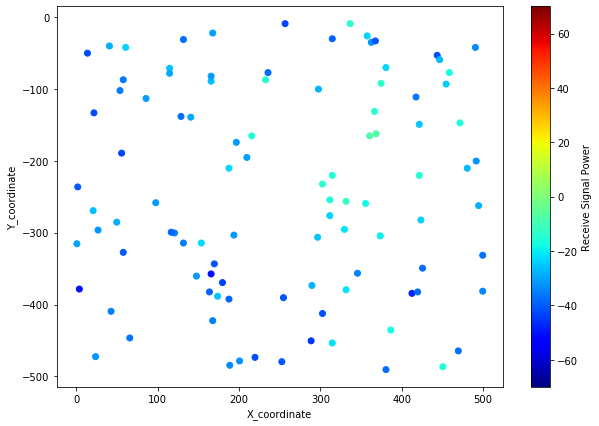

In [39]:
plt.figure(figsize=(10, 7))
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-70, vmax=70)
plt.scatter(x=x, y=y, c=power, cmap=cmap, norm=norm)
cb = plt.colorbar()
cb.set_label("Receive Signal Power")
plt.xlabel("X_coordinate")
plt.ylabel("Y_coordinate")

In [40]:
x.shape

(100,)